In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from numba import jit

In [2]:
data = np.loadtxt('TSPA.csv', delimiter=';').astype(np.int16)
data.shape

(200, 3)

In [3]:
def distance(xa, ya, xb, yb):
    return round(((xa-xb)**2+(ya-yb)**2)**(1/2))
distance(1,2,4,5)

4

In [4]:
def create_cost_matrix(data):
    distance_matrix = np.empty((0,len(data)), int)
    for i in range(len(data)):
        row = []
        for j in range(len(data)):
            if i != j:
                row.append(distance(data[i][0], data[i][1], data[j][0], data[j][1]))
            else:
                row.append(0)
        distance_matrix = np.append(distance_matrix, [row], axis=0)

    costs = data[:,2]
    #print(distance_matrix)
    cost_matrix = (distance_matrix + costs)
    return cost_matrix

cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

In [5]:
cost_matrix

array([[  84, 2032, 2098, ..., 4159, 3783, 1514],
       [1633,  483, 2398, ..., 3349, 2266,  817],
       [ 720, 1419, 1462, ..., 3640, 3149,  964],
       ...,
       [2782, 2371, 3641, ..., 1461, 2908, 2554],
       [2558, 1440, 3302, ..., 3060, 1309, 1773],
       [1234,  936, 2062, ..., 3651, 2718,  364]])

In [6]:
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix, 100)
print(solution)

[ 10 129   6  37  46 135  41 145  56  57  98  58  23 116  11 161 164  68
  45 105 144  35 108  93 140  47 121  33 189  62  77 114 190  99  40  96
  88  52 138  79 176  65   7 151  73 141 101  32  44 178  14  84  78 110
  54 113  55  92 155 136  42  87 193 103  38  67 187  91 111 185 171  20
  74  12 127 125 184 133 177  24 104  66 194 149 139 148 163  28  60  82
  95 143 197  63  16 196 160 158 156  39]


In [9]:
def calculate_objective_function(solution, cost_matrix):
    obj_func = 0
    for i in range(len(solution)-1):
        obj_func += cost_matrix[solution[i], solution[i+1]]
    obj_func += cost_matrix[solution[0], solution[-1]]
    return obj_func

calculate_objective_function(solution, cost_matrix)

88596

In [10]:
def nearest_neighbour(cost_matrix, current_id=random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    while len(solution) < limit:
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    return np.array(solution)

solution = nearest_neighbour(cost_matrix)
print(calculate_objective_function(solution, cost_matrix))

89469


In [11]:
def greedy_cycle(cost_matrix, current_id = random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)

    return np.array(solution)
        

solution = greedy_cycle(cost_matrix)
print(calculate_objective_function(solution, cost_matrix))

75895


===================================== <br> 
Use numba to accelerate functions (keep in mind that the first run will be slower due to compilation)

In [12]:
greedy_cycle_jit = jit()(greedy_cycle)

In [13]:
nearest_neighbour_jit = jit()(nearest_neighbour)

=====================================

In [14]:
def test_solver(solver, cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for i in range(n):
        solution = solver(cost_matrix, i)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [15]:
def test_random_solver(cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for _ in range(n):
        solution = random_solution(cost_matrix)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [16]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200)
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

RANDOM SOLUTION
AVERAGE: 266486.665
MINIMUM (BEST): 241088
MAXIMUM (WORST): 293208


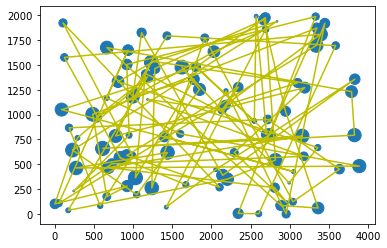

In [17]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 87741.23
MINIMUM (BEST): 84840
MAXIMUM (WORST): 95932


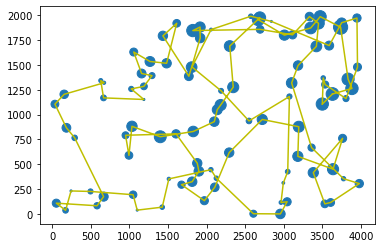

In [19]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

NEAREST NEIGHBOR
AVERAGE: 87741.23
MINIMUM (BEST): 84840
MAXIMUM (WORST): 95932


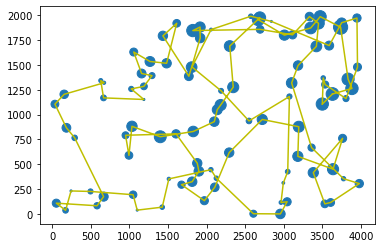

In [17]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 76387.4
MINIMUM (BEST): 74573
MAXIMUM (WORST): 79158


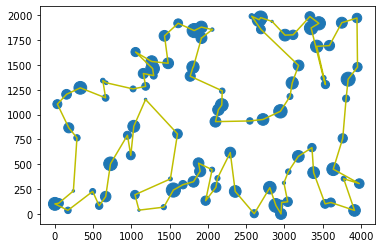

In [19]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

GREEDY CYCLE
AVERAGE: 76387.4
MINIMUM (BEST): 74573
MAXIMUM (WORST): 79158


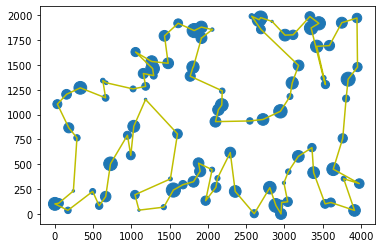

In [20]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

### Greedy cycle with and without jit

In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)

770 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)

1min 20s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Nearest Neighbour with and without jit

In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)

15.2 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(nearest_neighbour, cost_matrix, 200)

516 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


=================================

In [21]:
data = np.loadtxt('TSPB.csv', delimiter=';').astype(np.int16)
cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

RANDOM SOLUTION
AVERAGE: 265537.55
MINIMUM (BEST): 238404
MAXIMUM (WORST): 294227


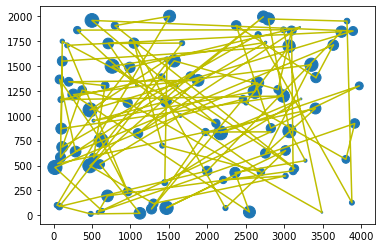

In [22]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 79096.295
MINIMUM (BEST): 77417
MAXIMUM (WORST): 81600


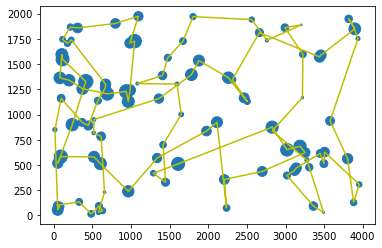

In [23]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

NEAREST NEIGHBOR
AVERAGE: 79096.295
MINIMUM (BEST): 77417
MAXIMUM (WORST): 81600


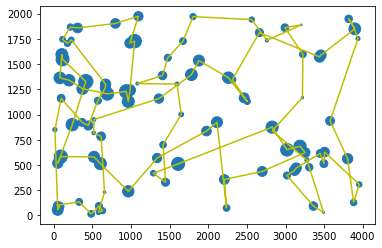

In [24]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 69961.23
MINIMUM (BEST): 67684
MAXIMUM (WORST): 75068


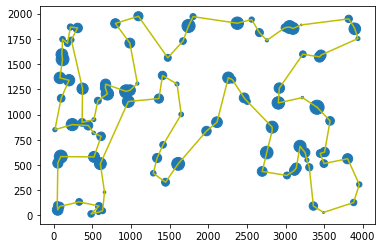

In [25]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

GREEDY CYCLE
AVERAGE: 69961.23
MINIMUM (BEST): 67684
MAXIMUM (WORST): 75068


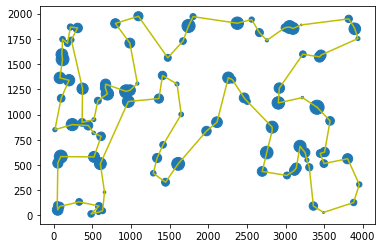

In [26]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)